# Household Analysis Visualization Dashboard

This notebook generates publication-ready visualizations for household work patterns and their relationship with egalitarianism scores.

## Visualizations Included:

1. **Correlation Matrix**: All household variables vs. normalized egalitarianism score
2. **Geographical Plots**: Choropleth maps for household work hours and spouse household work by country
3. **Bar Plots**: Gender distribution across household division of labor variables
4. **Composite Dashboard**: Time trends and relationships with egalitarianism score for key household variables

All outputs are saved to `images/static/` (PNG) and `images/interactive/` (HTML) directories.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import re

os.chdir('/Users/ashishpapanai/Desktop/MS_Tübingen/ML4102/')
os.makedirs('images/static', exist_ok=True)
os.makedirs('images/interactive', exist_ok=True)
# pink- #f678a7 female
# blue - #add2e4 male
COLOR_THEME = {
    # 'Male': '#0072B2',
    # 'Female': '#D55E00',
    'Male': '#56B4E9',
    'Female': '#f678a7',
    'Urban': '#56B4E9',
    'Rural': '#E69F00',
    'Male_Urban': '#0072B2',
    'Female_Urban': '#CC79A7',
    'Male_Rural': '#009E73',
    'Female_Rural': '#D55E00',
    'Done by Respondent': '#0072B2',
    'Done by Partner': '#CC79A7',
    'Equal': '#F0E442',
    '2002': '#0072B2',
    '2012': '#D55E00',
    '2022': '#009E73',
    'color_1': '#0072B2',
    'color_2': '#D55E00',
    'color_3': '#009E73',
    'color_4': '#CC79A7',
    'color_5': '#F0E442',
    'color_6': '#56B4E9',
    'color_7': '#E69F00',
    'color_8': '#000000',
    'neutral': '#808080',
    'background': '#FFFFFF',
}

print("✓ Setup complete")
print(f"✓ Output directories created: images/static/, images/interactive/")
print("✓ Colorblind-friendly color theme defined")


✓ Setup complete
✓ Output directories created: images/static/, images/interactive/
✓ Colorblind-friendly color theme defined


In [2]:
data_2002 = pd.read_csv('final_csv/2002.csv')
data_2012 = pd.read_csv('final_csv/2012.csv')
data_2022 = pd.read_csv('final_csv/2022.csv')

data_2002 = data_2002.loc[:, ~data_2002.columns.str.contains('^v\\d+', regex=True)]
data_2012 = data_2012.loc[:, ~data_2012.columns.str.contains('^v\\d+', regex=True)]
data_2022 = data_2022.loc[:, ~data_2022.columns.str.contains('^v\\d+', regex=True)]

data_2002['sex'] = data_2002['sex'].apply(lambda x: x.split(' ')[-1] if pd.notnull(x) else x)
data_2012['sex'] = data_2012['sex'].apply(lambda x: x.split(' ')[-1] if pd.notnull(x) else x)
data_2022['sex'] = data_2022['sex'].apply(lambda x: x.split(' ')[-1] if pd.notnull(x) else x)

cols_question_mapping = {
    'eg_score': 'Egalitarianism Score',
    'eg_score_norm': 'Egalitarianism Score Normalised',
    'urban_rural': 'Urban/Rural Classification',
    'sex': 'SEX',
    'age': 'Age of respondent',
    'COUNTRY': 'Country/ Sample ISO 3166 Code',
    'HOMPOP': 'How many persons in household',
    'HHADULT': 'Q24a How many people in hh: adults 18 yrs +',
    'HHCHILDR': 'Q24b How many people in hh:kids 6,7 - 17 yrs',
    'HHTODD': 'Q24c Number of people in hh: kids up to 5,6',
    'hh_wrk_hrs': 'Q16a How many hours spend on household work',
    'HH_FAM': 'Q16b How many hours spend on family members',
    'SP_HH': 'Q17a How many hours spouse, partner works on household',
    'SP_HH_FAM': 'Q17b How many hours spouse, partner spends on family members',
    'FAM_DIF': 'Q23b Difficult to fulfill family responsibility',
    'WORK_TIRED': 'Q16a Too tired from work to do duties at home',
    'HH_TIRED': 'Q16c Too tired from hhwork to function i job',
    'DIFF_CONC_WORK': 'Q16d Difficult to concentrate at work',
    'SHARE_HH': 'Q20 Sharing of household work between partners',
    'HH_WEEKEND': 'Q13a Final say: choosing weekend activities',
    'DIV_HH_LAUND': 'Q19a Division of household work: Doing the laundry',
    'DIV_HH_CARE': 'Q19c Division of household work: Care for sick family members',
    'DIV_HH_GROC': 'Q19d Division of household work: Shops for groceries',
    'DIV_HH_CLEAN': 'Q19e Division of household work: Household cleaning',
    'DIV_HH_COOK': 'Q19f Division of household work: Preparing meals',
    'MOMORFAF': 'Q2d Men should do larger share of childcare',
    'CASEID': 'Respondent ID',
}

all_years_data = []
for year, data in zip([2002, 2012, 2022], [data_2002, data_2012, data_2022]):
    df = data.copy()
    df['year'] = year
    df['sex'] = df['sex'].astype(str).str.strip().str.title()
    df['eg_score_norm'] = pd.to_numeric(
        df['eg_score_norm'].astype(str).str.replace(',', '.', regex=False),
        errors='coerce'
    )
    all_years_data.append(df)

composite_data = pd.concat(all_years_data, ignore_index=True)

print(f"✓ Data loaded: {len(composite_data):,} total observations")
print(f"✓ Years: {sorted(composite_data['year'].unique())}")


✓ Data loaded: 154,154 total observations
✓ Years: [np.int64(2002), np.int64(2012), np.int64(2022)]


In [3]:
def extract_country_code(val):
    """Extract ISO-2 country code from COUNTRY column"""
    if pd.isna(val):
        return None
    val_str = str(val).upper().strip()
    match = re.search(r'\b([A-Z]{2})(?:-[A-Z])?\b', val_str)
    if match:
        return match.group(1)
    match = re.search(r'\.\s*([A-Z]{2})-', val_str)
    if match:
        return match.group(1)
    match = re.search(r'([A-Z]{2})\s', val_str)
    if match:
        return match.group(1)
    if len(val_str) >= 2 and val_str[:2].isalpha():
        return val_str[:2]
    return None

ISO2_TO_ISO3 = {
    'AU': 'AUS', 'AT': 'AUT', 'BE': 'BEL', 'BR': 'BRA', 'BG': 'BGR',
    'CA': 'CAN', 'CL': 'CHL', 'CN': 'CHN', 'HR': 'HRV', 'CZ': 'CZE',
    'DK': 'DNK', 'FI': 'FIN', 'FR': 'FRA', 'DE': 'DEU', 'GR': 'GRC',
    'HU': 'HUN', 'IS': 'ISL', 'IN': 'IND', 'IE': 'IRL', 'IL': 'ISR',
    'IT': 'ITA', 'JP': 'JPN', 'KR': 'KOR', 'LV': 'LVA', 'LT': 'LTU',
    'MX': 'MEX', 'NL': 'NLD', 'NZ': 'NZL', 'NO': 'NOR', 'PH': 'PHL',
    'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 'RU': 'RUS', 'SK': 'SVK',
    'SI': 'SVN', 'ZA': 'ZAF', 'ES': 'ESP', 'SE': 'SWE', 'CH': 'CHE',
    'TW': 'TWN', 'TH': 'THA', 'TR': 'TUR', 'UA': 'UKR', 'GB': 'GBR',
    'US': 'USA', 'VE': 'VEN', 'VN': 'VNM', 'AR': 'ARG', 'BY': 'BLR',
    'CY': 'CYP', 'EE': 'EST', 'GT': 'GTM', 'HK': 'HKG', 'ID': 'IDN',
    'MY': 'MYS', 'PE': 'PER', 'SG': 'SGP', 'UY': 'URY'
}

def get_iso3_code(iso2_code):
    """Convert ISO-2 to ISO-3 country code"""
    if pd.isna(iso2_code) or iso2_code is None:
        return None
    iso2_code = str(iso2_code).upper().strip()
    try:
        import pycountry
        country = pycountry.countries.get(alpha_2=iso2_code)
        if country:
            return country.alpha_3
    except:
        pass
    return ISO2_TO_ISO3.get(iso2_code, iso2_code)

composite_data['country_code'] = composite_data['COUNTRY'].apply(extract_country_code)
composite_data['country_iso3'] = composite_data['country_code'].apply(get_iso3_code)

def format_title(text, max_words=6):
    """Split title into two lines if more than max_words"""
    words = text.split()
    if len(words) > max_words:
        mid = len(words) // 2
        return '<br>'.join([' '.join(words[:mid]), ' '.join(words[mid:])])
    return text

print("✓ Helper functions defined")
print(f"✓ Country codes extracted: {composite_data['country_code'].notna().sum():,} valid codes")


✓ Helper functions defined
✓ Country codes extracted: 154,154 valid codes


## 1. Correlation Matrix: Household Variables vs. Equality Score Score

This visualization shows the correlation between all numeric household variables and the normalized Equality Score score across all three survey years (2002, 2012, 2022).


In [4]:
numeric_vars = [
    'hh_wrk_hrs', 'SP_HH', 'HOMPOP', 'age', 'WW_FAM_SUFFER'
]
mapping_vars = [
    'Household Work Hours', 'Spouse Household Work Hours', 'Household Population', 'Age of Respondent', 'Family Suffers due to Working Women'
]

correlations = []
for var in numeric_vars:
    if var not in composite_data.columns:
        continue
    for year in [2002, 2012, 2022]:
        year_data = composite_data[
            (composite_data['year'] == year) &
            (composite_data['eg_score_norm'].notna()) &
            (composite_data[var].notna())
        ]
        
        year_data = year_data.copy()
        year_data[var] = pd.to_numeric(
            year_data[var].astype(str).str.replace(',', '.', regex=False),
            errors='coerce'
        )
        year_data = year_data.dropna(subset=[var, 'eg_score_norm'])
        
        if len(year_data) > 100:
            corr = year_data['eg_score_norm'].corr(year_data[var])
            if not pd.isna(corr):
                correlations.append({
                    'Variable': mapping_vars[numeric_vars.index(var)] if var in numeric_vars else var,
                    'Year': year,
                    'Correlation': corr
                })

if correlations:
    corr_df = pd.DataFrame(correlations)
    pivot_corr = corr_df.pivot(index='Variable', columns='Year', values='Correlation')
    
    fig = px.imshow(
        pivot_corr,
        text_auto='.2f',
        aspect="equal",
        color_continuous_scale='RdBu',
        range_color=[-1, 1],
        title=format_title("Correlation Matrix: Household Variables vs. Normalized Equality Score", max_words=6),
        labels=dict(x="Year", y="Variable", color="Correlation")
    )
    
    # Update text size inside cells
    fig.update_traces(textfont_size=25)
    
    fig.update_layout(
        height=800, # Increased height relative to width to accommodate 5 rows vs 3 cols
        width=1000,
        font=dict(size=14),
        title_font_size=27.5
    )
    fig.update_xaxes(tickmode='array', tickvals=[2002, 2012, 2022], ticktext=['2002', '2012', '2022'])
    
    fig.write_html('images/interactive/correlation_matrix_household_vars.html')
    fig.write_image('images/static/correlation_matrix_household_vars.png', width=600, height=800, scale=2)
    
    print("✓ Correlation matrix created")
    print(f"✓ Saved: images/static/correlation_matrix_household_vars.png")
    print(f"✓ Saved: images/interactive/correlation_matrix_household_vars.html")
    
    fig.show()
else:
    print("⚠ No correlations calculated. Check data availability.")

✓ Correlation matrix created
✓ Saved: images/static/correlation_matrix_household_vars.png
✓ Saved: images/interactive/correlation_matrix_household_vars.html


In [5]:
countries_2022 = data_2022['country'].unique()
countries_2002 = data_2002['country'].unique()
countries_2012 = data_2012['country'].unique()

common_countries = set(countries_2022) & set(countries_2002) & set(countries_2012)
print(f"Common countries in all three years: {common_countries}")

Common countries in all three years: {'FR', 'PL', 'JP', 'ES', 'NL', 'CH', 'US', 'IL', 'TW', 'NO', 'AU', 'CZ', 'HU', 'BG', 'SI', 'SK', 'SE', 'FI', 'RU', 'AT', 'PH', 'DK'}


In [6]:
def create_geographical_plot(var_name, var_label):
    """Create animated choropleth map for a variable"""
    plot_data = composite_data[
        (composite_data[var_name].notna()) &
        (composite_data['country_iso3'].notna()) &
        (composite_data['eg_score_norm'].notna())
    ].copy()

    plot_data = plot_data[plot_data['country'].isin(common_countries)]
    
    plot_data[var_name] = pd.to_numeric(
        plot_data[var_name].astype(str).str.replace(',', '.', regex=False),
        errors='coerce'
    )
    plot_data = plot_data.dropna(subset=[var_name])
    
    if len(plot_data) == 0:
        print(f"⚠ No data available for {var_name}")
        return None
    
    geo_agg = plot_data.groupby(['country_iso3', 'country_code', 'year']).agg({
        var_name: 'mean',
        'eg_score_norm': 'mean',
        'CASEID': 'count'
    }).reset_index()
    geo_agg.rename(columns={'CASEID': 'count'}, inplace=True)
    
    fig = px.choropleth(
        geo_agg,
        locations='country_iso3',
        locationmode='ISO-3',
        color=var_name,
        animation_frame='year',
        hover_name='country_code',
        hover_data={var_name: ':.2f', 'eg_score_norm': ':.2f', 'count': ':d'},
        color_continuous_scale='Viridis',
        title=format_title(f"Geographical Distribution: {var_label} (2002 → 2012 → 2022)"),
        labels={var_name: var_label}
    )
    
    fig.update_layout(
        height=600,
        width=1100,
        geo=dict(showframe=False, showcoastlines=True)
    )
    
    static_filename = f'geographical_{var_name}'
    fig.write_html(f'images/interactive/{static_filename}.html')
    fig_static = px.choropleth(
        geo_agg[geo_agg['year'] == 2022],
        locations='country_iso3',
        locationmode='ISO-3',
        color=var_name,
        hover_name='country_code',
        hover_data={var_name: ':.2f', 'eg_score_norm': ':.2f', 'count': ':d'},
        color_continuous_scale='Viridis',
        title=format_title(f"Geographical Distribution: {var_label} (2022)"),
        labels={var_name: var_label}
    )
    fig_static.update_layout(
        height=600,
        width=1100,
        geo=dict(showframe=False, showcoastlines=True)
    )
    fig_static.write_image(f'images/static/{static_filename}.png', width=1600, height=1000, scale=2)
    
    print(f"✓ Created geographical plot for {var_name}")
    print(f"  Saved: images/static/{static_filename}.png")
    print(f"  Saved: images/interactive/{static_filename}.html")
    
    return fig

fig_hh_wrk = create_geographical_plot('hh_wrk_hrs', 'Household Work Hours')
if fig_hh_wrk:
    fig_hh_wrk.show()

fig_sp_hh = create_geographical_plot('SP_HH', 'Spouse Household Work Hours')
if fig_sp_hh:
    fig_sp_hh.show()


✓ Created geographical plot for hh_wrk_hrs
  Saved: images/static/geographical_hh_wrk_hrs.png
  Saved: images/interactive/geographical_hh_wrk_hrs.html


✓ Created geographical plot for SP_HH
  Saved: images/static/geographical_SP_HH.png
  Saved: images/interactive/geographical_SP_HH.html


## 3. Bar Plots: Division of Household Labor by Gender

Grouped bar charts showing the distribution of household task division (laundry, care, groceries, cleaning, cooking) by gender (Male/Female) across all years.


In [7]:
div_vars = ['DIV_HH_LAUND', 'DIV_HH_CARE', 'DIV_HH_GROC', 'DIV_HH_CLEAN', 'DIV_HH_COOK']

bar_data = composite_data[
    (composite_data['sex'].isin(['Male', 'Female'])) &
    (composite_data[div_vars].notna().any(axis=1))
].copy()

subplot_titles = [format_title(cols_question_mapping.get(var, var)) for var in div_vars]
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.08,
    vertical_spacing=0.40
)

for idx, var in enumerate(div_vars):
    if idx < 3:
        row = 1
        col = idx + 1
    else:
        row = 2
        col = idx - 2
    
    var_data = bar_data[
        (bar_data[var].notna()) & 
        (~bar_data[var].astype(str).str.upper().isin(['NAP', 'N/A', 'NA']))
    ].copy()
    
    if len(var_data) == 0:
        continue
    
    counts = var_data.groupby(['sex', var]).size().reset_index(name='count')
    total_by_gender = var_data.groupby('sex').size().reset_index(name='total')
    counts = counts.merge(total_by_gender, on='sex')
    counts['percentage'] = (counts['count'] / counts['total']) * 100
    
    categories = sorted([c for c in counts[var].unique() 
                        if pd.notna(c) and str(c).upper() not in ['NAP', 'N/A', 'NA']])
    
    for sex in ['Male', 'Female']:
        sex_data = counts[counts['sex'] == sex]
        category_values = []
        for cat in categories:
            cat_data = sex_data[sex_data[var] == cat]
            if len(cat_data) > 0:
                category_values.append(cat_data['percentage'].values[0])
            else:
                category_values.append(0)
        
        fig.add_trace(
            go.Bar(
                x=categories,
                y=category_values,
                name=sex,
                showlegend=(idx == 0),  # Show legend only for first subplot
                marker_color='#1f77b4' if sex == 'Male' else '#d62728'
            ),
            row=row, col=col
        )
    
    fig.update_xaxes(title_text="Category", row=row, col=col, tickangle=45)
    if idx == 0:
        fig.update_yaxes(title_text="Percentage (%)", row=row, col=col)

fig.update_layout(
    title_text=format_title("Division of Household Labor by Gender"),
    height=700,
    width=2000,
    barmode='group',
    showlegend=True,
    legend=dict(yanchor="top", y=1.02, xanchor="left", x=0)
)

fig.write_html('images/interactive/bar_plot_div_hh_by_gender.html')
fig.write_image('images/static/bar_plot_div_hh_by_gender.png', width=2000, height=600, scale=2)

print("✓ Bar plots created")
print(f"✓ Saved: images/static/bar_plot_div_hh_by_gender.png")
print(f"✓ Saved: images/interactive/bar_plot_div_hh_by_gender.html")

fig.show()


✓ Bar plots created
✓ Saved: images/static/bar_plot_div_hh_by_gender.png
✓ Saved: images/interactive/bar_plot_div_hh_by_gender.html


In [8]:
div_vars = ['DIV_HH_LAUND', 'DIV_HH_CARE', 'DIV_HH_GROC', 'DIV_HH_CLEAN', 'DIV_HH_COOK']

def categorize_div_hh(value):
    """Categorize DIV_HH variable into: Done by Respondent, Done by Partner, or Equal"""
    if pd.isna(value):
        return None
    value_str = str(value).strip()
    
    if value_str in ['Always respondent', 'Usually respondent']:
        return 'Done by Respondent'
    elif value_str in ['Always partner', 'Usually partner']:
        return 'Done by Partner'
    elif value_str == 'About equal':
        return 'Equal'
    else:
        return None

analysis_data = composite_data[
    (composite_data['eg_score_norm'].notna()) &
    (composite_data[div_vars].notna().any(axis=1))
].copy()

for var in div_vars:
    analysis_data[f'{var}_group'] = analysis_data[var].apply(categorize_div_hh)

subplot_titles = [format_title(cols_question_mapping.get(var, var)) for var in div_vars]
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.10,
    vertical_spacing=0.20
)

legend_seen = set()

group_colors = {
    'Done by Respondent': '#2E86AB',
    'Done by Partner': '#A23B72',
    'Equal': '#F18F01'
}
for idx, var in enumerate(div_vars):
    if idx < 3:
        row = 1
        col = idx + 1
    else:
        row = 2
        col = idx - 2
    
    var_data = analysis_data[
        (analysis_data[f'{var}_group'].notna()) &
        (analysis_data['eg_score_norm'].notna()) &
        (analysis_data['sex'].isin(['Male', 'Female']))
    ].copy()
    
    if len(var_data) == 0:
        continue
    
    group_stats = var_data.groupby([f'{var}_group', 'sex'])['eg_score_norm'].agg([
        'mean', 'std', 'count'
    ]).reset_index()
    group_stats.columns = ['group', 'sex', 'mean_eg_score', 'std_eg_score', 'count']
    
    total_count = group_stats['count'].sum()
    group_stats['percentage'] = (group_stats['count'] / total_count) * 100
    
    for grp in group_stats['group'].unique():
        grp_total = group_stats[group_stats['group'] == grp]['count'].sum()
        if grp_total > 0:
            group_stats.loc[group_stats['group'] == grp, 'percentage_within_group'] = (
                group_stats.loc[group_stats['group'] == grp, 'count'] / grp_total * 100
            )
        else:
            group_stats.loc[group_stats['group'] == grp, 'percentage_within_group'] = 0
    
    group_order = ['Done by Respondent', 'Equal', 'Done by Partner']
    group_stats = group_stats[group_stats['group'].isin(group_order)]
    group_stats['group'] = pd.Categorical(group_stats['group'], categories=group_order, ordered=True)
    group_stats = group_stats.sort_values(['group', 'sex'])
    
    gender_colors = {
        'Male': '#1f77b4',
        'Female': '#f678a7'
    }
    
    for sex in ['Male', 'Female']:
        sex_data = group_stats[group_stats['sex'] == sex]
        if len(sex_data) == 0:
            continue

        show_legend = sex not in legend_seen
        if show_legend:
            legend_seen.add(sex)

        fig.add_trace(
            go.Bar(
                x=sex_data['group'],
                y=sex_data['mean_eg_score'],
                name=sex,
                showlegend=show_legend,
                legendgroup=sex,
                marker_color=gender_colors[sex],
                error_y=dict(
                    type='data',
                    array=sex_data['std_eg_score'],
                    visible=True
                ),
                text=[f"{p:.1f}%" for p in sex_data['percentage_within_group']],
                textposition='outside',
                hovertemplate=f'<b>{sex} - %{{x}}</b><br>Mean EG Score: %{{y:.3f}}<br>Std: %{{customdata[0]:.3f}}<br>Percentage (within group): %{{customdata[3]:.1f}}%<br>Count: %{{customdata[1]:d}}<extra></extra>',
                customdata=sex_data[['std_eg_score', 'count', 'percentage', 'percentage_within_group']].values
            ),
            row=row, col=col
        )
    
    fig.update_xaxes(title_text="Task Division Group", row=row, col=col, tickangle=0)
    if idx == 0:
        fig.update_yaxes(title_text="Mean EG Score", row=row, col=col)

fig.update_layout(
    title_text=format_title("Mean Egalitarianism Score by Household Task Division Groups and Gender", max_words=100),
    height=800,
    width=2000,
    barmode='group',
    showlegend=True,
    legend=dict(yanchor="top", y=1.02, xanchor="left", x=0),
    yaxis=dict(range=[0, 1]),
    margin=dict(t=150, b=50, l=50, r=50)
)

fig.write_html('images/interactive/div_hh_groups_eg_score.html')
fig.write_image('images/static/div_hh_groups_eg_score.png', width=2000, height=800, scale=2)

print("✓ DIV_HH groups vs EG score plots created")
print(f"✓ Saved: images/static/div_hh_groups_eg_score.png")
print(f"✓ Saved: images/interactive/div_hh_groups_eg_score.html")

print("\n=== Summary Statistics: Mean EG Score by Task Division Group and Gender ===")
for var in div_vars:
    var_data = analysis_data[
        (analysis_data[f'{var}_group'].notna()) &
        (analysis_data['eg_score_norm'].notna()) &
        (analysis_data['sex'].isin(['Male', 'Female']))
    ].copy()
    
    if len(var_data) > 0:
        summary = var_data.groupby([f'{var}_group', 'sex'])['eg_score_norm'].agg([
            'mean', 'std', 'count'
        ]).round(3)
        print(f"\n{cols_question_mapping.get(var, var)}:")
        print(summary)

fig.show()


✓ DIV_HH groups vs EG score plots created
✓ Saved: images/static/div_hh_groups_eg_score.png
✓ Saved: images/interactive/div_hh_groups_eg_score.html

=== Summary Statistics: Mean EG Score by Task Division Group and Gender ===

Q19a Division of household work: Doing the laundry:
                            mean    std  count
DIV_HH_LAUND_group sex                        
Done by Partner    Female  0.590  0.225   2138
                   Male    0.518  0.206  31672
Done by Respondent Female  0.556  0.216  40195
                   Male    0.527  0.216   4804
Equal              Female  0.634  0.218   5773
                   Male    0.588  0.213   7138

Q19c Division of household work: Care for sick family members:
                            mean    std  count
DIV_HH_CARE_group  sex                        
Done by Partner    Female  0.516  0.207   1837
                   Male    0.499  0.201  15108
Done by Respondent Female  0.539  0.213  24109
                   Male    0.483  0.202   3705


## 4. Composite Dashboard: Household Variables vs. Egalitarianism Score

This dashboard shows time trends (left column) and relationships with egalitarianism score (right column) for key household variables: household work hours, spouse household work, and household population.


In [9]:
dashboard_vars = ['hh_wrk_hrs', 'SP_HH', 'HOMPOP']

def aggregate_for_dashboard(df, var):
    """Aggregate data by year and sex"""
    plot_df = df[
        df['eg_score_norm'].notna() &
        df[var].notna() &
        df['sex'].isin(['Male', 'Female'])
    ].copy()
    
    if len(plot_df) == 0:
        return None
    
    plot_df[f'{var}_numeric'] = pd.to_numeric(
        plot_df[var].astype(str).str.replace(',', '.', regex=False),
        errors='coerce'
    )
    plot_df = plot_df.dropna(subset=[f'{var}_numeric'])
    
    if len(plot_df) == 0:
        return None
    
    agg_df = plot_df.groupby(['year', 'sex']).agg({
        f'{var}_numeric': 'mean',
        'eg_score_norm': 'mean'
    }).reset_index()
    
    agg_df.columns = ['year', 'sex', f'{var}_mean', 'eg_score_norm_mean']
    
    return agg_df

n_vars = len(dashboard_vars)
fig = make_subplots(
    rows=n_vars, cols=2,
    subplot_titles=[],
    vertical_spacing=0.12,
    horizontal_spacing=0.10,
    specs=[[{"secondary_y": False}, {"secondary_y": False}]
           for _ in range(n_vars)]
)

color_map = {
    'Male': '#56B4E9',
    'Female': '#f678a7'
}

legend_groups_used = set()

for var_idx, var in enumerate(dashboard_vars):
    var_label = cols_question_mapping.get(var, var)
    print(f"Total number of countries in the dataset: {len(composite_data['country'].unique())}")
    composite_data_country = composite_data[composite_data['country'].isin(common_countries)]
    print(f"Total number of countries in the dataset after filtering: {len(composite_data_country['country'].unique())}")
    agg_df = aggregate_for_dashboard(composite_data_country, var)
    
    if agg_df is None or len(agg_df) == 0:
        continue
    
    row = var_idx + 1
    
    # Time-series by gender
    col = 1
    for sex in ['Male', 'Female']:
        subset = agg_df[
            agg_df['sex'] == sex
        ].sort_values('year')
        
        if len(subset) > 0:
            color = color_map.get(sex, '#808080')
            show_legend = sex not in legend_groups_used
            if show_legend:
                legend_groups_used.add(sex)
            
            fig.add_trace(
                go.Scatter(
                    x=subset['year'],
                    y=subset[f'{var}_mean'],
                    mode='markers',
                    name=sex,
                    marker=dict(color=color, size=7, opacity=0.8),
                    # line=dict(color=color, width=2.5, shape='spline'),
                    legendgroup=sex,
                    showlegend=show_legend,
                    hovertemplate=f'<b>{var_label}</b><br>Year: %{{x}}<br>Value: %{{y:.2f}}<br>{sex}<extra></extra>'
                ),
                row=row, col=col
            )
    
    # Scatter vs EG score by gender and year
    col = 2
    marker_symbols = {2002: 'circle', 2012: 'x', 2022: 'cross'}
    
    for sex in ['Male', 'Female']:
        sex_subset = agg_df[agg_df['sex'] == sex]
        color = color_map.get(sex, '#808080')
        
        for year in [2002, 2012, 2022]:
            subset = sex_subset[sex_subset['year'] == year]
            if len(subset) > 0:
                symbol = marker_symbols[year]
                show_legend = sex not in legend_groups_used
                if show_legend:
                    legend_groups_used.add(sex)
                
                fig.add_trace(
                    go.Scatter(
                        x=subset['eg_score_norm_mean'],
                        y=subset[f'{var}_mean'],
                        mode='markers',
                        name=sex,
                        marker=dict(
                            color=color,
                            size=8,
                            opacity=0.7,
                            symbol=symbol
                        ),
                        legendgroup=sex,
                        showlegend=show_legend,
                        hovertemplate=f'<b>{var_label}</b><br>EG Score: %{{x:.3f}}<br>Value: %{{y:.2f}}<br>{sex} - {year}<extra></extra>'
                    ),
                    row=row, col=col
                )
        
        # Note: Curve fitting removed - with only 3 data points (2002, 2012, 2022),
        # fitting a trend line (1D polynomial) would be statistically invalid.
        # A linear fit with 3 points essentially just connects the dots and doesn't
        # provide meaningful insight into trends. The scatter plot with distinct
        # markers for each year is sufficient for visualization.
    
    fig.update_xaxes(
        title_text="Year" if row == n_vars else "",
        tickmode='array',
        tickvals=[2002, 2012, 2022],
        ticktext=['2002', '2012', '2022'],
        row=row, col=1
    )
    fig.update_yaxes(
        title_text="Average Value",
        row=row, col=1
    )
    fig.update_xaxes(
        title_text="EG Score (Normalized)",
        row=row, col=2
    )
    fig.update_yaxes(
        title_text="Average Value",
        row=row, col=2
    )

year_legend_traces = [
    go.Scatter(x=[None], y=[None], mode='markers', name='2002',
               marker=dict(symbol='circle', size=12, color='#666666'), showlegend=True),
    go.Scatter(x=[None], y=[None], mode='markers', name='2012',
               marker=dict(symbol='x', size=12, color='#666666'), showlegend=True),
    go.Scatter(x=[None], y=[None], mode='markers', name='2022',
               marker=dict(symbol='cross', size=12, color='#666666'), showlegend=True),
]
for trace in year_legend_traces:
    fig.add_trace(trace)

row_titles_annotations = []
vertical_spacing = 0.12

for var_idx, var in enumerate(dashboard_vars):
    var_label = format_title(cols_question_mapping.get(var, var))
    row = var_idx + 1
    
    total_plot_height = 1 - (n_vars - 1) * vertical_spacing
    row_height = total_plot_height / n_vars
    row_y_pos = 1 - (row - 1) * (row_height + vertical_spacing) - row_height / 2
    
    row_titles_annotations.append(
        dict(
            text=var_label,
            xref='paper',
            yref='paper',
            x=-0.075,
            y=row_y_pos,
            xanchor='right',
            yanchor='middle',
            textangle=-90,
            showarrow=False,
            font=dict(size=11, color='#2c3e50', family='Arial'),
            bgcolor='rgba(255, 255, 255, 0.9)',
            bordercolor='rgba(0, 0, 0, 0.2)',
            borderwidth=1,
            borderpad=4
        )
    )

fig.update_layout(
    template='plotly_white',
    height=1400 if n_vars == 3 else 1000,
    width=1400,
    title_text=format_title("Composite Analysis: Key Household Variables Over Time & Relationship with Egalitarianism", max_words=100),
    showlegend=True,
    legend=dict(
        title=dict(text='Gender', font=dict(size=12)),
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=1.02
    ),
    margin=dict(l=130, r=100, t=100, b=120),
    annotations=row_titles_annotations
)

fig.write_html('images/interactive/composite_dashboard_hh_vars.html')
fig.write_image('images/static/composite_dashboard_hh_vars.png', width=1600, height=1600, scale=2)

print("✓ Composite dashboard created")
print(f"✓ Saved: images/static/composite_dashboard_hh_vars.png")
print(f"✓ Saved: images/interactive/composite_dashboard_hh_vars.html")

fig.show()


Total number of countries in the dataset: 52
Total number of countries in the dataset after filtering: 22
Total number of countries in the dataset: 52
Total number of countries in the dataset after filtering: 22
Total number of countries in the dataset: 52
Total number of countries in the dataset after filtering: 22
✓ Composite dashboard created
✓ Saved: images/static/composite_dashboard_hh_vars.png
✓ Saved: images/interactive/composite_dashboard_hh_vars.html


In [10]:

dashboard_vars = ['hh_wrk_hrs', 'SP_HH', 'HOMPOP']

# # Identify countries present in all three waves for consistent trend analysis
# countries_by_year = composite_data.groupby('year')['country_iso3'].unique()
# common_countries = set(countries_by_year[2002])
# for y in [2012, 2022]:
#     if y in countries_by_year:
#         common_countries = common_countries & set(countries_by_year[y])

# print(f"✓ Filtering for {len(common_countries)} countries present in all survey waves")
# composite_data_common = composite_data[composite_data['country_iso3'].isin(common_countries)].copy()

def aggregate_for_dashboard(df, var):
    """Aggregate data by year and sex"""
    plot_df = df[
        df['eg_score_norm'].notna() &
        df[var].notna() &
        df['sex'].isin(['Male', 'Female'])
    ].copy()
    
    if len(plot_df) == 0:
        return None
    
    plot_df[f'{var}_numeric'] = pd.to_numeric(
        plot_df[var].astype(str).str.replace(',', '.', regex=False),
        errors='coerce'
    )
    plot_df = plot_df.dropna(subset=[f'{var}_numeric'])
    
    if len(plot_df) == 0:
        return None
    
    agg_df = plot_df.groupby(['year', 'sex']).agg({
        f'{var}_numeric': 'mean',
        'eg_score_norm': 'mean'
    }).reset_index()
    
    agg_df.columns = ['year', 'sex', f'{var}_mean', 'eg_score_norm_mean']
    
    return agg_df

color_map = {
    'Male': '#56B4E9',
    'Female': '#f678a7'
}

for var_idx, var in enumerate(dashboard_vars):
    var_label = cols_question_mapping.get(var, var)
    agg_df = aggregate_for_dashboard(composite_data, var)
    
    if agg_df is None or len(agg_df) == 0:
        continue
    
    # Create separate figure for each variable
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Time Trend (2002-2022)", "Correlation with Egalitarianism"],
        horizontal_spacing=0.15,
        vertical_spacing=0.15
    )
    
    legend_groups_used = set()
    
    # Plot 1: Time-series by gender
    for sex in ['Male', 'Female']:
        subset = agg_df[agg_df['sex'] == sex].sort_values('year')
        
        if len(subset) > 0:
            color = color_map.get(sex, '#808080')
            show_legend = sex not in legend_groups_used
            if show_legend:
                legend_groups_used.add(sex)
            
            fig.add_trace(
                go.Scatter(
                    x=subset['year'],
                    y=subset[f'{var}_mean'],
                    mode='markers',
                    name=sex,
                    marker=dict(color=color, size=9),
                    line=dict(color=color, width=3),
                    legendgroup=sex,
                    showlegend=show_legend,
                    hovertemplate=f'<b>{var_label}</b><br>Year: %{{x}}<br>Value: %{{y:.2f}}<br>{sex}<extra></extra>'
                ),
                row=1, col=1
            )
            
    # Plot 2: Scatter vs EG score by gender and year
    marker_symbols = {2002: 'circle', 2012: 'x', 2022: 'cross'}
    
    for sex in ['Male', 'Female']:
        sex_subset = agg_df[agg_df['sex'] == sex]
        color = color_map.get(sex, '#808080')
        
        for year in [2002, 2012, 2022]:
            subset = sex_subset[sex_subset['year'] == year]
            if len(subset) > 0:
                symbol = marker_symbols[year]
                
                fig.add_trace(
                    go.Scatter(
                        x=subset['eg_score_norm_mean'],
                        y=subset[f'{var}_mean'],
                        mode='markers',
                        name=sex,
                        marker=dict(
                            color=color,
                            size=10,
                            opacity=0.8,
                            symbol=symbol
                        ),
                        legendgroup=sex,
                        showlegend=False,
                        hovertemplate=f'<b>{var_label}</b><br>EG Score: %{{x:.3f}}<br>Value: %{{y:.2f}}<br>{sex} - {year}<extra></extra>'
                    ),
                    row=1, col=2
                )

    # Add dummy traces for Year legend
    year_legend_traces = [
        go.Scatter(x=[None], y=[None], mode='markers', name='2002',
                   marker=dict(symbol='circle', size=10, color='#666666'), showlegend=True),
        go.Scatter(x=[None], y=[None], mode='markers', name='2012',
                   marker=dict(symbol='x', size=10, color='#666666'), showlegend=True),
        go.Scatter(x=[None], y=[None], mode='markers', name='2022',
                   marker=dict(symbol='cross', size=10, color='#666666'), showlegend=True),
    ]
    for trace in year_legend_traces:
        fig.add_trace(trace, row=1, col=2)

    # Layout updates
    if len(var_label.split()) > 6:
        var_label = format_title(var_label, max_words=6)
    fig.update_xaxes(title_text="Year", tickmode='array', tickvals=[2002, 2012, 2022], row=1, col=1)
    fig.update_yaxes(title_text=f"Mean {var_label}", row=1, col=1)
    fig.update_xaxes(title_text="Egalitarianism Score (Normalized)", row=1, col=2)
    fig.update_yaxes(title_text=f"Mean {var_label}", row=1, col=2)
    
    fig.update_layout(
        template='plotly_white',
        height=500,
        width=1200,
        title_text=format_title(f"Analysis: {var_label} (Common Countries Only)", max_words=100),
        showlegend=True,
        legend=dict(
            title_text="Legend", 
            yanchor="top", 
            y=0.98,
            xanchor="left",
            x=1.02
        ),
        margin=dict(t=150, r=150)
    )
    
    filename = f"dashboard_{var}"
    fig.write_html(f'images/interactive/{filename}.html')
    fig.write_image(f'images/static/{filename}.png', width=1200, height=500, scale=2)
    
    print(f"✓ Created dashboard for {var}")
    print(f"  Saved: images/static/{filename}.png")
    
    fig.show()

✓ Created dashboard for hh_wrk_hrs
  Saved: images/static/dashboard_hh_wrk_hrs.png


✓ Created dashboard for SP_HH
  Saved: images/static/dashboard_SP_HH.png


✓ Created dashboard for HOMPOP
  Saved: images/static/dashboard_HOMPOP.png


In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

style_map = {
    'hh_wrk_hrs': {'symbol': 'circle', 'pattern': ''},
    'SP_HH':      {'symbol': 'square', 'pattern': '/'},
    'HOMPOP':     {'symbol': 'diamond', 'pattern': '.'}
}

color_map = {
    'Male': '#56B4E9',
    'Female': '#f678a7'
}

# Male is larger (background), Female is smaller (foreground)
sex_size_map = {
    'Male': 15,
    'Female': 9
}

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Time Trend (2002-2022)", "Correlation with Equality Score"],
    horizontal_spacing=0.15,
    vertical_spacing=0.15
)

# Loop through variables
for var in dashboard_vars:
    legend_label_base = var 
    
    full_label = cols_question_mapping.get(var, var)
    if len(full_label.split()) > 10:
        full_label = " ".join(full_label.split()[:10]) + "..."
        
    agg_df = aggregate_for_dashboard(composite_data, var)
    
    if agg_df is None or len(agg_df) == 0:
        continue
    
    var_style = style_map.get(var, {'symbol': 'circle'})
    
    # Loop strictly 'Male' then 'Female' to ensure correct layering
    for sex in ['Male', 'Female']:
        subset = agg_df[agg_df['sex'] == sex].sort_values('year')
        
        if len(subset) == 0:
            continue

        color = color_map.get(sex, '#808080')
        marker_size = sex_size_map.get(sex, 10)
        
        trace_name = f"{sex} - {legend_label_base}"
        unique_group = f"{sex}_{var}"

        # 1. Time Trend
        fig.add_trace(
            go.Scatter(
                x=subset['year'],
                y=subset[f'{var}_mean'],
                mode='markers',
                name=trace_name,
                legendgroup=unique_group,
                marker=dict(
                    symbol=var_style['symbol'], 
                    size=marker_size, 
                    color=color,
                    opacity=1.0, # Fully opaque as requested
                    line=dict(width=1, color='white')
                ),
                hovertemplate=f'<b>{legend_label_base}</b><br>Question: {full_label}<br>Year: %{{x}}<br>Mean: %{{y:.2f}}<br>{sex}<extra></extra>'
            ),
            row=1, col=1
        )

        # 2. Correlation Plot
        fig.add_trace(
            go.Scatter(
                x=subset['eg_score_norm_mean'],
                y=subset[f'{var}_mean'],
                mode='markers',
                name=trace_name,
                legendgroup=unique_group,
                showlegend=False,
                marker=dict(
                    symbol=var_style['symbol'],
                    size=marker_size,
                    color=color,
                    opacity=1.0,
                    line=dict(width=1, color='white')
                ),
                hovertemplate=f'<b>{legend_label_base}</b><br>Question: {full_label}<br>EG Score: %{{x:.3f}}<br>Mean: %{{y:.2f}}<br>Year: %{{text}}<extra></extra>',
                text=subset['year']
            ),
            row=1, col=2
        )

fig.update_xaxes(title_text="Year", tickmode='array', tickvals=[2002, 2012, 2022], row=1, col=1)
fig.update_yaxes(title_text="Mean Value", row=1, col=1)

fig.update_xaxes(title_text="Equality Score (Normalized)", row=1, col=2)
fig.update_yaxes(title_text="Mean Value", row=1, col=2)

fig.update_layout(
    template='plotly_white',
    height=600,
    width=1300,
    title_text="Combined Analysis: Trends and Correlations across Variables",
    showlegend=True,
    legend=dict(
        title_text="Variable & Sex", 
        yanchor="top", 
        y=1,
        xanchor="left",
        x=1.02,
        font=dict(size=10)
    ),
    margin=dict(t=100, r=200)
)

filename = "dashboard_combined_vars"
fig.write_html(f'images/interactive/{filename}.html')
fig.write_image(f'images/static/{filename}.png', width=1300, height=600, scale=2)
print(f"✓ Saved: images/static/{filename}.png")
print(f"✓ Created combined dashboard")
fig.show()

✓ Saved: images/static/dashboard_combined_vars.png
✓ Created combined dashboard


In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import os

os.makedirs('images/static', exist_ok=True)
os.makedirs('images/interactive', exist_ok=True)

dashboard_vars = ['hh_wrk_hrs', 'SP_HH', 'HOMPOP']

style_map = {
    'hh_wrk_hrs': {'symbol': 'circle', 'pattern': ''},
    'SP_HH':      {'symbol': 'square', 'pattern': '/'},
    'HOMPOP':     {'symbol': 'diamond', 'pattern': '.'}
}

color_map = {
    'Male': '#56B4E9',
    'Female': '#f678a7'
}

sex_size_map = {
    'Male': 15,
    'Female': 9
}

def get_trendline(df, x_col, y_col):
    try:
        valid = df.dropna(subset=[x_col, y_col])
        if len(valid) < 2: 
            return None, None
        
        z = np.polyfit(valid[x_col], valid[y_col], 1)
        p = np.poly1d(z)
        
        x_range = np.linspace(valid[x_col].min(), valid[x_col].max(), 50)
        return x_range, p(x_range)
    except:
        return None, None

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Time Trend (2002-2022)", "Correlation with Equality Score"],
    horizontal_spacing=0.12,
    vertical_spacing=0.1
)

for var in dashboard_vars:
    legend_label_base = var 
    full_label = cols_question_mapping.get(var, var)
    if len(full_label.split()) > 10:
        full_label = " ".join(full_label.split()[:10]) + "..."
        
    agg_df = aggregate_for_dashboard(composite_data, var)
    
    if agg_df is None or len(agg_df) == 0:
        continue
    
    var_style = style_map.get(var, {'symbol': 'circle'})
    
    for sex in ['Male', 'Female']:
        subset = agg_df[agg_df['sex'] == sex].sort_values('year')
        
        if len(subset) == 0:
            continue

        color = color_map.get(sex, '#808080')
        marker_size = sex_size_map.get(sex, 10)
        trace_name = f"{sex} - {var}"
        unique_group = f"{sex}_{var}"

        fig.add_trace(
            go.Scatter(
                x=subset['year'],
                y=subset[f'{var}_mean'],
                mode='markers',
                name=trace_name,
                legendgroup=unique_group,
                showlegend=False,
                marker=dict(
                    symbol=var_style['symbol'], 
                    size=marker_size, 
                    color=color,
                    opacity=1.0,
                    line=dict(width=1, color='white')
                ),
                hovertemplate=f'<b>{legend_label_base}</b><br>Year: %{{x}}<br>Mean: %{{y:.2f}}<br>{sex}<extra></extra>'
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=subset['eg_score_norm_mean'],
                y=subset[f'{var}_mean'],
                mode='markers',
                name=trace_name,
                legendgroup=unique_group,
                showlegend=True,
                marker=dict(
                    symbol=var_style['symbol'],
                    size=marker_size,
                    color=color,
                    opacity=1.0,
                    line=dict(width=1, color='white')
                ),
                hovertemplate=f'<b>{legend_label_base}</b><br>EG Score: %{{x:.3f}}<br>Mean: %{{y:.2f}}<br>Year: %{{text}}<extra></extra>',
                text=subset['year']
            ),
            row=1, col=2
        )
        
        tx, ty = get_trendline(subset, 'eg_score_norm_mean', f'{var}_mean')
        if tx is not None:
            fig.add_trace(
                go.Scatter(
                    x=tx, y=ty,
                    mode='lines',
                    name=f'{trace_name} Trend',
                    legendgroup=unique_group,
                    showlegend=False,
                    line=dict(
                        color=color, 
                        width=2, 
                        dash='dot'
                    ),
                    hoverinfo='skip'
                ),
                row=1, col=2
            )

fig.update_layout(
    template='plotly_white',
    height=600,
    width=1300,
    title=dict(
        text="Combined Analysis: Trends and Correlations across Variables",
        font=dict(size=24)
    ),
    legend=dict(
        title_text="Variable & Sex", 
        yanchor="top", 
        y=1,
        xanchor="left",
        x=1.02,
        font=dict(size=14)
    ),
    margin=dict(t=100, r=200, b=80, l=80)
)

fig.update_xaxes(title_text="Year", tickmode='array', tickvals=[2002, 2012, 2022], row=1, col=1)
fig.update_yaxes(title_text="Mean Value", row=1, col=1)

fig.update_xaxes(title_text="Equality Score (Normalized)", row=1, col=2)
fig.update_yaxes(title_text="Mean Value", row=1, col=2)

filename = "dashboard_combined_vars"
fig.write_html(f'images/interactive/{filename}.html')
fig.write_image(f'images/static/{filename}.png', width=1300, height=600, scale=2)

print(f"✓ Saved: images/static/{filename}.png")
print(f"✓ Saved: images/interactive/{filename}.html")

fig.show()

✓ Saved: images/static/dashboard_combined_vars.png
✓ Saved: images/interactive/dashboard_combined_vars.html


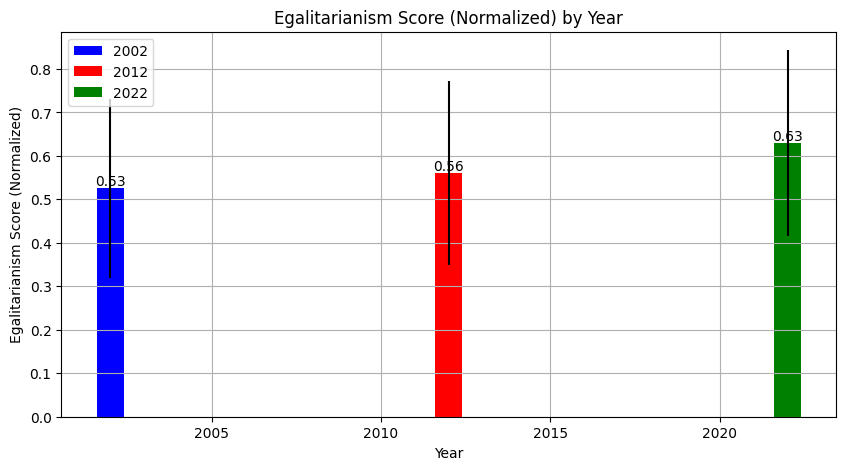

In [12]:
# composite_data_country.eg_score_norm.describe() plot for each year
import matplotlib.pyplot as plt
eg_score_norm_2002 = composite_data_country[composite_data_country['year'] == 2002]['eg_score_norm']
eg_score_norm_2012 = composite_data_country[composite_data_country['year'] == 2012]['eg_score_norm']
eg_score_norm_2022 = composite_data_country[composite_data_country['year'] == 2022]['eg_score_norm']

plt.figure(figsize=(10, 5))
# plot as one bar for each year
plt.bar(2002, eg_score_norm_2002.mean(), yerr=eg_score_norm_2002.std(), color='blue')
plt.bar(2012, eg_score_norm_2012.mean(), yerr=eg_score_norm_2012.std(), color='red')
plt.bar(2022, eg_score_norm_2022.mean(), yerr=eg_score_norm_2022.std(), color='green')
plt.text(2002, eg_score_norm_2002.mean(), f"{eg_score_norm_2002.mean():.2f}", ha='center', va='bottom')
plt.text(2012, eg_score_norm_2012.mean(), f"{eg_score_norm_2012.mean():.2f}", ha='center', va='bottom')
plt.text(2022, eg_score_norm_2022.mean(), f"{eg_score_norm_2022.mean():.2f}", ha='center', va='bottom')
plt.xlabel('Year')
plt.grid(True)  
plt.ylabel('Egalitarianism Score (Normalized)')
plt.title('Egalitarianism Score (Normalized) by Year')
plt.legend(['2002', '2012', '2022'], loc='upper left')
plt.show()


In [13]:
composite_data_country.to_csv('data/composite_data_country.csv', index=False)

## Summary

All visualizations have been generated and saved to:
- **Static images (PNG)**: `images/static/`
- **Interactive plots (HTML)**: `images/interactive/`

### Key Findings:

1. **Correlation Matrix**: Shows which household variables have the strongest relationships with egalitarianism scores across years.

2. **Geographical Plots**: Reveal country-level patterns in household work hours and spouse contributions, with temporal changes visible through animation.

3. **Bar Plots**: Demonstrate gender differences in the division of household labor across five key tasks.

4. **Composite Dashboard**: Provides a comprehensive view of how household variables change over time and relate to egalitarianism scores, broken down by gender and urban/rural classification.
